# Variational Auto-Encoders

In [1]:
import torch
import numpy as np
from tqdm import tqdm
from loguru import logger

# check if gpu available
logger.info(torch.cuda.is_available())

device = torch.device("cuda" if torch.has_cuda else "cpu")
# print gpu name
if device:
    logger.info(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    logger.info('Using CPU')

2023-09-29 13:20:43.104 | INFO     | __main__:<module>:7 - True
2023-09-29 13:20:43.115 | INFO     | __main__:<module>:12 - GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


### DATA

In [92]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])

dataset_path = "../datasets/"
train_set = MNIST(dataset_path, train=True, transform=mnist_transform, download=True)
val_set = MNIST(dataset_path, train=False, transform=mnist_transform, download=True)

batch_size=256
train_loader = DataLoader(train_set, batch_size, shuffle=True, pin_memory=True, num_workers=1)
val_loader = DataLoader(val_set, batch_size, shuffle=True, pin_memory=True, num_workers=1)

for batch_idx, (x,y) in enumerate(train_loader):
    logger.info(f"X shape: {x.shape} // X min: {x.min()} X max: {x.max()} ")
    logger.info(f"Y shape: {y.shape}")
    break


2023-09-24 04:25:39.314 | INFO     | __main__:<module>:16 - X shape: torch.Size([256, 784]) // X min: 0.0 X max: 1.0 
2023-09-24 04:25:39.319 | INFO     | __main__:<module>:17 - Y shape: torch.Size([256])


### MODEL

In [93]:
import torch.nn as nn
from torch import sigmoid

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.x1 = nn.Linear(input_dim, hidden_dim)
        self.x2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.variance = nn.Linear(hidden_dim, latent_dim)
        self.act = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        f = self.act(self.x1(x))
        f = self.act(self.x2(f))
        mean = self.mean(f)
        variance = self.variance(f)

        return mean, variance

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.x1 = nn.Linear(latent_dim, hidden_dim)
        self.x2 = nn.Linear(hidden_dim, hidden_dim)
        self.x3 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.LeakyReLU(0.2)
    
    def forward(self, l):
        f = self.act(self.x1(l))
        f = self.act(self.x2(f))
        output = sigmoid(self.act(self.x3(f)))

        return output
    
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim)

    def sample_randn(self, mean, var):
        r = torch.randn_like(var).to(device)
        z = mean + r*var  # z = m*r + s generates samples from normal distribution with mean(m) and sigma(s)
        return z
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.sample_randn(mean, torch.exp(0.5*log_var)) # 0.5 since we're converting variance to sigma (var=pow(sigma, 2))
        return self.decoder(z), mean, log_var
    
# model parameters
input_dim=784 #NOTE: change for different image size (28x28=784)
hidden_dim=512
latent_dim=256
vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device=device)

### LOSS and OPTIMIZER

In [94]:
from torch.optim import Adam
from torch.nn import BCELoss

optim = Adam(vae_model.parameters(), lr=1.e-3)

bce_loss = BCELoss(reduction='sum')

def loss_func(pred, gt, mean, log_var):
    
    def generative_loss(pred, gt):
        return nn.functional.binary_cross_entropy(pred, gt, reduction='sum')
    
    # taken from here: https://medium.com/@outerrencedl/variational-autoencoder-and-a-bit-kl-divergence-with-pytorch-ce04fd55d0d7
    def kld_loss(m, lv):
        return 0.5*torch.sum(m.pow(2)+lv.exp()-1-lv)
    
    return generative_loss(pred, gt) + kld_loss(mean, log_var)

### TRAINING LOOP

In [95]:
num_epochs = 50

for epoch in range(num_epochs):
    loss_sum = 0.
    for batch_idx, (x,_) in enumerate(train_loader):
        x=x.to(device=device)
        optim.zero_grad()
        y_hat, m, v = vae_model.forward(x)
        loss = loss_func(y_hat, x, m, v)
        loss_sum +=loss.item()
        loss.backward()
        optim.step()
        if batch_idx%200==0:
            logger.info(f"Epoch: {epoch} / Batch idx: {batch_idx} / loss: {loss.item()/batch_size:0.5f}")
    logger.info(f"------------   Epoch: {epoch} / Mean loss: {loss_sum/(len(train_loader)*batch_size):0.5f} -------------")
logger.info(f"Training complete: Total epochs: {epoch+1} / Final Mean loss: {loss_sum/(len(train_loader)*batch_size):0.5f}")

2023-09-24 04:25:39.527 | INFO     | __main__:<module>:14 - Epoch: 0 / Batch idx: 0 / loss: 553.79340


2023-09-24 04:25:46.606 | INFO     | __main__:<module>:14 - Epoch: 0 / Batch idx: 200 / loss: 192.59839
2023-09-24 04:25:47.823 | INFO     | __main__:<module>:15 - ------------   Epoch: 0 / Mean loss: 214.69221 -------------
2023-09-24 04:25:47.914 | INFO     | __main__:<module>:14 - Epoch: 1 / Batch idx: 0 / loss: 193.41066
2023-09-24 04:25:54.988 | INFO     | __main__:<module>:14 - Epoch: 1 / Batch idx: 200 / loss: 167.39661
2023-09-24 04:25:56.212 | INFO     | __main__:<module>:15 - ------------   Epoch: 1 / Mean loss: 180.24735 -------------
2023-09-24 04:25:56.300 | INFO     | __main__:<module>:14 - Epoch: 2 / Batch idx: 0 / loss: 167.62863
2023-09-24 04:26:03.529 | INFO     | __main__:<module>:14 - Epoch: 2 / Batch idx: 200 / loss: 149.13235
2023-09-24 04:26:04.698 | INFO     | __main__:<module>:15 - ------------   Epoch: 2 / Mean loss: 153.78649 -------------
2023-09-24 04:26:04.788 | INFO     | __main__:<module>:14 - Epoch: 3 / Batch idx: 0 / loss: 144.23686
2023-09-24 04:26:11

### TEST

In [99]:
import matplotlib.pyplot as plt
from numpy import random
def plot_img(x, idx=0):
    x = x.view(batch_size, 28, 28)
    fig=plt.figure()
    plt.imshow(x[idx].cpu().numpy())

2023-09-24 05:09:51.714 | INFO     | __main__:<module>:10 - GT: 3


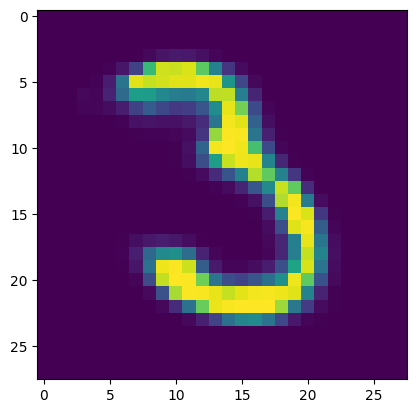

In [114]:
vae_model.eval()

with torch.no_grad():
    for batch_idx, (x,y) in enumerate(val_loader):
        x=x.to(device=device)
        output, _, _ = vae_model(x)
        break

random_idx = random.randint(0,batch_size)
logger.info(f"GT: {y[random_idx]}")
plot_img(output, random_idx)